In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import warnings
from dna_features_viewer import GraphicFeature, GraphicRecord, BiopythonTranslator
warnings.filterwarnings('ignore')

In [2]:
O_ag_gene_list = ['yibK', 'wzc', 'wzb', 'wza', 'galE', 'gne', 'wpaD',
                  'ugd', 'wpaC', 'wpaB', 'wzy', 'wpaA', 'wzx', 'qdtB',
                  'qdtA', 'rmlA', 'qdtf', 'cpxA', 'wec', 'rffG', 'rffH']

In [3]:
def find_o_ag_genes_data_from_gff(gff_file, O_ag_gene_list):
    """
    Function gets data (start and end coordinates, strand (+,-)) on candidate O-antigen operon genes from GFF annotation
    using list of O-antigen operon genes defined from literature
    :param gff_file: path to GFF annotation file (PGAP)
    :param O_ag_gene_list: list of O-antigen operon genes defined from literature
    :return: 2-D array with 4 columns: start coordinate, end coordinate, strand, gene name
    """

    ncbi_gff = pd.read_csv(gff_file,
                           sep='\t', comment="#").dropna()
    ncbi_gff.columns = [i for i in range(1, len(ncbi_gff.columns) + 1)]
    ncbi_gff_gene = ncbi_gff.loc[ncbi_gff[3] == 'gene']
    ncbi_gff_gene.index = range(ncbi_gff_gene.shape[0])
    ncbi_gff_gene.loc[:, 10] = ncbi_gff_gene[9].apply(lambda x: x.split('Name=')[1].split(';')[0])

    return ncbi_gff_gene[
               ncbi_gff_gene[9].apply(lambda x: any([k in x for k in O_ag_gene_list]))
           ].loc[:, [4, 5, 7, 10]].to_numpy()


In [4]:
def find_o_ag_operon_numbers(operons_df, coord_genes_array):
    """
    Function gets candidate O-ag operons (as operon numbers) from Operon-mapper output
    using coordinates array of O-ag genes obtained from GFF annotation
    :param operons_df: pandas DataFrame of Operon-mapper output with the description of predicted operons
    :param coord_genes_array: 2-D array with the following columns: start coordinate, end coordinate, strand, gene name.
    :return: numpy array: operon numbers of candidate O-antigen operons
    """
    return operons_df.dropna().loc[
        (operons_df.dropna().PosLeft.isin(coord_genes_array[:, 0])) &
        (operons_df.postRight.isin(coord_genes_array[:, 1])) |
        (operons_df.dropna().Function.str.contains('O-antigen'))
    ]['Operon'].unique()

In [5]:
def get_operon_boundaries(operons_df, operon_numbers_list):
    """
    Function gets boundary coordinates of the DNA region specified as the list of operons.
    :param operons_df: pandas DataFrame of Operon-mapper output with the description of predicted operons
    :param operon_numbers_list: list of operon numbers (int) predicted by Operon-mapper
    :return: tuple consisting of 2 integers:
    (<start_coordinate_of_the_first_gene_from_the_first_operon>, <end_coordinate_of_the_last_gene_from_the_last_operon>)
    """
    operon_boundaries = operons_df[
                            operons_df.Operon.isin(operon_numbers_list)
                        ].iloc[[1, -1], :].loc[:, ['PosLeft', 'postRight']].to_numpy()
    return tuple(map(int, [operon_boundaries[0][0], operon_boundaries[1][1]]))


In [6]:
def draw_region_by_coordinates(gff_file, start_, end_):
    """
    Function produces schematic plot of DNA region specified with coordinates;
    visualizes only gene feature types
    and labels them by gene or its product.
    :param gff_file: path to GFF annotation file from PGAP
    :param start_: start coordinate of the desired region
    :param end_: end coordinate of the desired region
    :return: None
    """
    biopython_translator = BiopythonTranslator()
    biopython_translator.ignored_features_types = ['CDS']
    biopython_translator.label_fields = ["gene", "product"]
    graphic_record = biopython_translator.translate_record(gff_file)

    graphic_record.crop((start_, end_)).plot()

In [7]:
coord_genes_array = find_o_ag_genes_data_from_gff('GCF_000973125.1_ASM97312v1_genomic.gff', O_ag_gene_list)

In [8]:
operons_df = pd.read_csv("59353/list_of_operons_59353", sep='\t')
operons_df["Operon"] = operons_df["Operon"].ffill()

In [9]:
operons_df.head()

,Operon,IdGene,Type,COGgene,PosLeft,postRight,Strand,Function
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,dnaA,CDS,COG0593,332.0,1720.0,+,[L] ATPase involved in DNA replication initiation
2,1.0,dnaN,CDS,COG0592,1725.0,2825.0,+,[L] DNA polymerase sliding clamp subunit (PCNA
3,1.0,recF,CDS,COG1195,2843.0,3934.0,+,[L] Recombinational DNA repair ATPase (RecF pa...
4,1.0,gyrB,CDS,COG0187,3953.0,6367.0,+,"[L] Type IIA topoisomerase (DNA gyrase/topo II,"


In [10]:
find_o_ag_operon_numbers(operons_df, coord_genes_array)

array([1890., 2185., 2242., 2245., 2257.])

In [11]:
get_operon_boundaries(operons_df, [1890])

(3826209, 3827225)

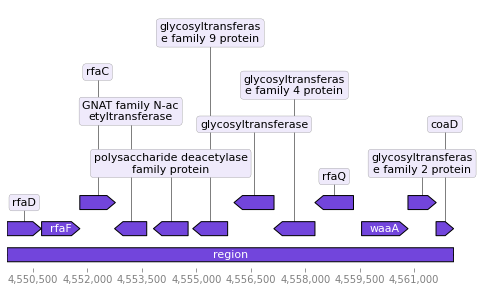

In [12]:
# 2251, 2252, 2253, 2254, 2255 operons
start, end = get_operon_boundaries(operons_df, [2251, 2252, 2253, 2254,2255])
draw_region_by_coordinates('GCF_000973125.1_ASM97312v1_genomic2.gff', start, end)

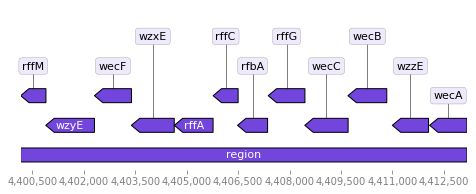

In [13]:
# 2185 operon
start, end = get_operon_boundaries(operons_df, [2185])
draw_region_by_coordinates('GCF_000973125.1_ASM97312v1_genomic2.gff', start-1, end)

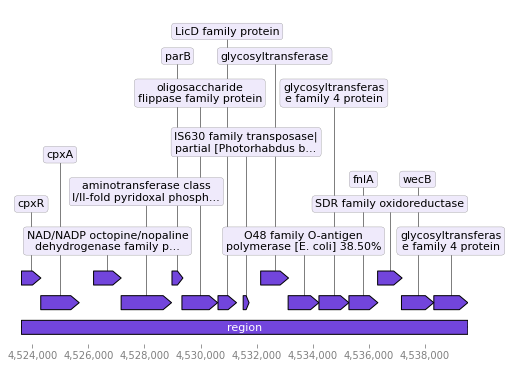

In [14]:
# 2242, 2243,2244, 2245 operons
start, end = get_operon_boundaries(operons_df, [2242, 2243,2244, 2245])
draw_region_by_coordinates('GCF_000973125.1_ASM97312v1_genomic2.gff', start-1, end)